### 03 WebサーチをするAIエージェント
#### 03_01 ReAct
- Google Colabに必要なライブラリをインストール
- transformersを使ってLLMモデルをHugging Faceから読み込み
- MCPサーバ(ddg-search)によるweb検索の実装
- LangGraphによるReActの実装
- 動作確認

**Google Colabに必要なライブラリをインストール**
- 1行にまとめることで pip が全パッケージの依存関係を一括解決する。
- 分割すると後勝ちで依存関係が壊れるリスクがある。
  > （transformersとlangchain-huggingfaceで、huggingface-hubのバージョンが衝突する等）
- NOTE: Colab では uv ではなく pip を使う。
  > uv は依存解決の過程でnumpy 等をアップグレードし、プリインストール済みの scipy 等を壊すため。

In [ ]:
# Google Colabに必要なライブラリをインストールする。
# 1行にまとめることで pip が全パッケージの依存関係を一括解決する。
# 分割すると後勝ちで依存関係が壊れるリスクがある。
# （transformersとlangchain-huggingfaceで、huggingface-hubのバージョンが衝突する等）
# NOTE: Colab では uv ではなく pip を使う。uv は依存解決の過程で
#       numpy 等をアップグレードし、プリインストール済みの scipy 等を壊すため。
# NOTE: langchain 関連は 1.x 系に明示的に指定する。
#       Colab プリインストールの 0.3.x が残ると langchain-mcp-adapters が動作しない。
%pip install -U transformers accelerate bitsandbytes \
     "langchain>=1.2.8" "langchain-core>=1.2.8" \
     "langchain-huggingface>=1.2.0" "langgraph>=1.0.7" \
     "langchain-mcp-adapters>=0.2.1" duckduckgo-mcp-server mcp

**transformersを使ってLLMモデルをHugging Faceから読み込み**

##### LLM バックエンドの選定

このリポジトリでは **transformers + bitsandbytes** を採用。
- Colab GPU との相性が良い
- 量子化などの細かい設定が可能
- 非同期処理に対応

**将来の本番環境向け:**
- 非同期/スケーラビリティ重視が必要となる場合、Ollamaなどサーバ管理されたものを使用する。

In [6]:
# transformersを使ってLLMモデルをHugging Faceから読み込みする。
import torch  # type: ignore
from transformers import (  # type: ignore
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,  # noqa: F401
    pipeline,
)  # type: ignore
from langchain_huggingface import HuggingFacePipeline, ChatHuggingFace  # type: ignore

model_name = "ibm-granite/granite-4.0-h-micro"  # Hugging Faceのモデルの名称

# LLMモデルの量子化の設定
# quantization_config = BitsAndBytesConfig(
#     load_in_4bit=True,  # 4 ビットに量子化された形式で読み込むように指定
#     bnb_4bit_quant_type="nf4",  # 4 ビット量子化のデータ型として NF4 を指定
#     bnb_4bit_use_double_quant=True,  # 二重量子化の指定
#     bnb_4bit_compute_dtype=torch.bfloat16,  # 計算時のデータ型を指定
# )

# LLMに生成させる文章の計算条件
generation_params = {
    "do_sample": True,
    "temperature": 0.8,
    "top_k": 40,
    "top_p": 0.9,
    "repetition_penalty": 1.1,
    "max_new_tokens": 512,
}

# LLMモデルの読み込み
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,  # Hugging Faceから読み込みするモデルの名称
    # quantization_config=quantization_config,
    dtype=torch.bfloat16,  # 読み込みするモデルのデータ型（transformers 4.x では torch_dtype）
    device_map="auto",  # 読み込んだモデルを CPU / GPUに自動で割り当てする指示
)

# transformersのパイプライン
hf_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    return_full_text=False,  # 入力プロンプトを出力に含めない
)

# LangChainのHuggingFaceパイプラインに接続
llm = HuggingFacePipeline(pipeline=hf_pipeline, pipeline_kwargs=generation_params)

# チャットモデルインターフェースとして接続（チャットテンプレート対応）
chat_llm = ChatHuggingFace(llm=llm)

# モデルのメモリ消費量（バイト）を取得し、GBに変換して表示
memory_footprint_bytes = model.get_memory_footprint()
memory_footprint_gb = memory_footprint_bytes / (1024 * 1024 * 1024)
print(f"モデルのメモリ消費量: {memory_footprint_gb:.2f} GB")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cpu


モデルのメモリ消費量: 5.94 GB


**MCPサーバ(ddg-search)によるweb検索の実装**
- langchain-mcp-adapters の MultiServerMCPClient を使用。
- MCPサーバのツールが自動的に LangChain ツールに変換される（@tool の手動定義が不要）。
- ReActエージェントが bind_tools() で認識し、自律的にツールを呼び出せる形式になる。

**MCPサーバ設定の補足**

github に記載されているMCP接続の設定は以下
> "mcpServers": {"ddg-search": {"command": "uvx", "args": ["duckduckgo-mcp-server"]}}

今回は、pip install済なので、command="duckduckgo-mcp-server" で直接起動。uvx経由ではないので、args=[] としてよい。

**Colab の stderr 問題の回避（Colab 特有。通常の Python 環境では不要）**

Colab の stderr は fileno() 未対応のため、MCP の stdio_client が失敗する。
stdio_client の関数シグネチャ `errlog=sys.stderr` は**インポート時に評価が確定**するため、
後から sys.stderr を差し替えても効果がない（Python のデフォルト引数の仕様）。
そこで、langchain_mcp_adapters.sessions 内の stdio_client 参照自体を、
errlog のデフォルトを /dev/null に変更したラッパー関数に差し替えて回避する。

1. /dev/null を書き込みモードで開き、`_devnull` として保持する（stderr の代替出力先）。
2. 差し替え前のオリジナル `stdio_client` への参照を `_original_stdio_client` に退避する。
3. ラッパー関数 `_patched_stdio_client` を定義する。errlog のデフォルト値だけを `_devnull` に変更し、内部ではオリジナルの `stdio_client` を呼び出す。
4. `@contextlib.asynccontextmanager` と `yield` により async with 構文に対応し、MCP セッション完了まで errlog の差し替えが維持される。
5. `_sessions.stdio_client` の参照先をラッパー関数に差し替えることで、MultiServerMCPClient が内部で呼ぶ stdio_client もパッチ済みになる。

In [ ]:
# MCPサーバ（duckduckgo-mcp-server）に接続し、LangChainツールを自動取得
# langchain-mcp-adapters が MCP ツールを LangChain 互換に自動変換するため、
# @tool による手動ラップが不要
import os
import contextlib
from langchain_mcp_adapters import sessions as _sessions  # type: ignore
from langchain_mcp_adapters.client import MultiServerMCPClient  # type: ignore

# --- Colab stderr 問題の回避パッチ（Colab 特有。通常環境では不要） ---
# stdio_client(server, errlog=sys.stderr) のデフォルト値はインポート時に確定する。
# Colab の stderr は fileno() 未対応のため、デフォルトのまま呼ぶと失敗する。
# → errlog のデフォルトを /dev/null に差し替えたラッパーで上書きして回避する。
# NOTE: _devnull はセッション中ずっと開いたままにする（閉じると書き込み先がなくなる）
_devnull = open(os.devnull, "w")
_original_stdio_client = _sessions.stdio_client


@contextlib.asynccontextmanager
async def _patched_stdio_client(server, errlog=_devnull):
    async with _original_stdio_client(server, errlog=errlog) as result:
        yield result


_sessions.stdio_client = _patched_stdio_client

# --- MCPサーバに接続 ---
mcp_client = MultiServerMCPClient(
    {
        "ddg-search": {
            "transport": "stdio",
            "command": "duckduckgo-mcp-server",
            "args": [],
        }
    }
)

# MCP ツールを LangChain ツールとして自動取得
tools = await mcp_client.get_tools()

print("=== ReActエージェント用ツール ===")
for t in tools:
    print(f"  - {t.name}: {t.description}")

**LangGraphによるLLMのメモリ管理**
- chat_nodeで、前のセルで作成したLLMモデルを呼び出した際の処理を設定。
  > 今回は人間のプロンプトをLLMに入力して、LLMから応答を取得する処理。
- LangGraphのグラフを構築し、ノードとエッジを設定し、グラフをcompileする。
  > 今回は単純だが、各処理をつなげて自動化させる場合に効果を発揮する。
- InMemorySaverを使用して、LLMとの会話をメモリに保存させる。
  > LLMとのチャット履歴が保持されるようになる。
- 作成したグラフを図示する。

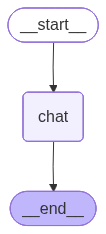

In [3]:
# LangGraph によるメモリ付きチャットグラフの構築
# InMemorySaver を使って、スレッド（thread_id）ごとに会話履歴を保持する
from langgraph.graph import StateGraph, MessagesState, START, END  # type: ignore
from langgraph.checkpoint.memory import InMemorySaver  # type: ignore
from IPython.display import Image, display


# チャットノード：現在の会話履歴を LLM に送信し、返答を生成
def chat_node(state: MessagesState):
    response = chat_llm.invoke(state["messages"])
    return {"messages": [response]}


# グラフの構築
graph = StateGraph(MessagesState)
graph.add_node("chat", chat_node)
graph.add_edge(START, "chat")
graph.add_edge("chat", END)

# InMemorySaver：スレッドごとに会話履歴をインメモリで保持
memory = InMemorySaver()
app = graph.compile(checkpointer=memory)

# 構築したグラフを図示
display(Image(app.get_graph().draw_mermaid_png()))

**LangGraph/LangChainによるチャット**
- SystemMessageでシステムプロンプトを、HumanMessageでユーザのプロンプトを設定する。
- configで指定したthread_idごとに会話履歴が保持される。
- 2回目の質問で前の会話を踏まえた回答が返れば、メモリが正常に動作している証拠。

In [4]:
# マルチターン会話のテスト
# 同じ thread_id でLLMを複数回呼び出すと、会話履歴が自動的に保持される
from langchain_core.messages import HumanMessage, SystemMessage  # type: ignore

config = {"configurable": {"thread_id": "thread_1"}}

# 1回目の質問（システムプロンプト付き）
response1 = app.invoke(
    {
        "messages": [
            SystemMessage(content="日本語で回答してください。"),
            HumanMessage(content="私はジョンです。日本で一番高い山は？"),
        ]
    },
    config=config,
)
print("=== 1回目の返答 ===")
print(response1["messages"][-1].content)

# 2回目の質問（前の会話を踏まえて回答できれば、メモリが動作している証拠）
response2 = app.invoke(
    {
        "messages": [
            HumanMessage(
                content="私の名前は何ですか？先ほど答えた山の高さは何メートルですか？"
            ),
        ]
    },
    config=config,
)
print("\n=== 2回目の返答 ===")
print(response2["messages"][-1].content)

=== 1回目の返答 ===
日本で一番高い山は、富士山です。

富士山は、山梨県と静岡県にまたがっています。標高は3,776.24mです。

=== 2回目の返答 ===
あなたの名前はジョンです。

富士山は、標高3,776.24mです。


**MCPサーバ（duckduckgo-mcp-server）によるWeb検索**
- MCPサーバ（duckduckgo-mcp-server）を stdio 経由で起動し、検索ツールを取得する。
  > AIに自律的に検索ツールを使わせるのではなく、今回（notebook 02）はユーザがMCPサーバを実行。
- 検索結果をコンテキストとして LLM に渡し、回答を生成させる。
  > gemma-3-1b はツールコール非対応のため、検索→LLM回答の2段構成とする。

**MCPサーバ設定の補足**

github に記載されているMCP接続の設定は以下
> "mcpServers": {"ddg-search": {"command": "uvx", "args": ["duckduckgo-mcp-server"]}}

今回は、pip install済なので、command="duckduckgo-mcp-server" で直接起動。uvx経由ではないので、args=[] としてよい。

**stdio_client接続の補足**

async with stdio_client(server_params) as (read, write):を、次に修正している。
  > async with stdio_client(server_params, errlog=open(os.devnull, "w")) as (read, write):

これはColab環境特有の処置で、Colabの内部構造が標準的なstderrに対応していないため。

In [5]:
# MCPサーバ（duckduckgo-mcp-server）に接続して検索し、結果をLLMに渡す
# Colab環境ではasyncioのインポートなしで非同期処理（async/await）が使用可能
# 通常のPython環境では、asyncioのインポートが必要
import os
from mcp import ClientSession, StdioServerParameters  # type: ignore
from mcp.client.stdio import stdio_client  # type: ignore
from langchain_core.messages import HumanMessage, SystemMessage  # type: ignore

# MCPサーバへの接続パラメータ（stdio 経由で起動）
server_params = StdioServerParameters(
    command="duckduckgo-mcp-server",
    args=[],
)

query = "2025年 日本の総人口"

# MCPサーバに接続し、検索ツールを取得して実行
# NOTE: Colab の stderr は fileno() 未対応のため、errlog をファイルに迂回する
async with stdio_client(server_params, errlog=open(os.devnull, "w")) as (read, write):
    async with ClientSession(read, write) as session:
        await session.initialize()

        # MCPサーバが提供するツール一覧を表示
        tools = await session.list_tools()
        print("=== 利用可能なツール ===")
        for t in tools.tools:
            print(f"  - {t.name}: {t.description}")

        # 検索ツールを実行（max_results で検索結果数を制限）
        result = await session.call_tool("search", {"query": query, "max_results": 3})

# 検索結果を取得
search_results = result.content[0].text
print("\n=== 検索結果 ===")
print(search_results)

# 検索結果をコンテキストとしてLLMに質問
config = {"configurable": {"thread_id": "thread_search"}}
response = app.invoke(
    {
        "messages": [
            SystemMessage(
                content="以下の検索結果をもとに、ユーザの質問に日本語で簡潔に回答してください。"
            ),
            HumanMessage(content=f"質問: {query}\n\n検索結果:\n{search_results}"),
        ]
    },
    config=config,
)
print("\n=== LLMの回答 ===")
print(response["messages"][-1].content)

=== 利用可能なツール ===
  - search: 
    Search DuckDuckGo and return formatted results.

    Args:
        query: The search query string
        max_results: Maximum number of results to return (default: 10)
        ctx: MCP context for logging
    
  - fetch_content: 
    Fetch and parse content from a webpage URL.

    Args:
        url: The webpage URL to fetch content from
        ctx: MCP context for logging
    

=== 検索結果 ===
Found 3 search results:

1. 人口推計（2025年（令和7年）8月確定値、2026年（令和8年）1月概算値） （2026年1月20日公表）
   URL: https://www.stat.go.jp/data/jinsui/new.htm
   Summary: 2026年（令和8年）1月報 （2025年（令和7年）8月確定値、2026年（令和8年）1月概算値）（PDF：346KB） 統計表 統計表 （政府統計の総合窓口「e-Stat」 掲載の統計表） ※ その他の推計結果 各月1日現在人口 「全国：年齢（5歳階級）、男女別人口」 各年10月1日現在人口 「全国：年齢（各歳）、男女別 ...

2. 我が国の人口について｜厚生労働省 - mhlw.go.jp
   URL: https://www.mhlw.go.jp/stf/newpage_21481.html
   Summary: 日本の人口は近年減少局面を迎えており、2070年には総人口が9,000万人を割り込み、高齢化率は39％の水準になると推計されています。 また、団塊の世代の方々が全て75歳となる2025年には、75歳以上の人口が全人口の約18％となり、2040年には65歳以上の人口が全人口の約35％となると推計されてい ...